# DDPM Implementation

Author: George Witt

Project Span: 05/15/23 TO 05/19/23

DUE: 05/19/23 MIDNIGHT.

See supplemental paper and website for extra details and graphics.

# NOTE FOR READER

**NOTE FOR GRADER**

Please see the document for this as well, but the github link with the full library needed for computation is here https://github.com/georgew79/PHYS486_FinalProject_Diffusers.git



In [1]:
import numpy as np
import torch
import time
import torchvision
import os

from PIL import Image
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

from Lib.data_loading import load_data, standardize
from Lib.viz_data import viz_mnist, viz_mnist_wchannel, save_images
from Lib.noise import calc_alpha_ts, calc_alpha_ts_bar, linear_var_schedule, gauss_noise_step

from Lib.models import DDPM, ema_trainer

from torch.utils.tensorboard import SummaryWriter

## MNIST Dataset

The DDPM (Denoising Diffusion Probabilistic Model) network is a diffusion-based network focused on learning the reverse transition of noise applied to a given training set. In other words, given a set X on which multiple steps of randomly sampled Gaussian noise is added, can we determine a consistent method to reverse the noise (ie noise step -> org. image) that minimizes the loss. This approach can be used for a variety of tasks, from generating images, to generating videos, to even solving NP problems like the Euler TSP (Traveling Salesman) problem.

To demonstrate DDPM implementation, we begin with its implementation on the MNIST dataset.

Please refer to the full write-up for technical details and a formal explanation of the topics in this notebook. This notebook only provides brief notes on certain sections of the code, while the full mathematical write-up and derivations are provided in the accompanying paper itself.

Let us begin by considering the steps of the DDPM network.

Training:

    1) Given a batch of some images, process them through a noise scheduler.
    2) Given a batch of noised images, denoise them with the model.
    3) Evaluate performance and optimize the network.  

In [2]:
# Load data
(mnist_x, mnist_y), (mnist_x_test, mnist_y_test), info = load_data('mnist')

print("MNIST X Shape: ", mnist_x.shape)
print("MNIST X Test Shape: ", mnist_x_test.shape)
print("MNIST Y Shape: ", mnist_y.shape)
print("MNIST Y Test Shape: ", mnist_y_test.shape)

MNIST X Shape:  (60000, 784)
MNIST X Test Shape:  (10000, 784)
MNIST Y Shape:  (60000,)
MNIST Y Test Shape:  (10000,)


In [3]:
# Data is organized in full arrays of 784 values. The original images are 28 x 28, let's preprocess all this by reverting
# BACK to the 28 x 28 image sets.

mnist_x = mnist_x.reshape(mnist_x.shape[0], 28, 28)
mnist_x_test = mnist_x_test.reshape(mnist_x_test.shape[0], 28, 28)

We have now loaded the data, preprocessed it, and prepared it. Let's take a look at the values we have present.

In [4]:
# Some sample values...
print("Sample value 1:", mnist_x[0][0])
print("Sample value 2:", mnist_x[0][3])
print("etc.")

Sample value 1: [-0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386]
Sample value 2: [-0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386 -0.33400386
 -0.33400386 -0.33400386 -0.33400386 -0.33400386]
etc.


Everything is already normalized and prepared. Let's now visualize some images to ensure everything is working right. 

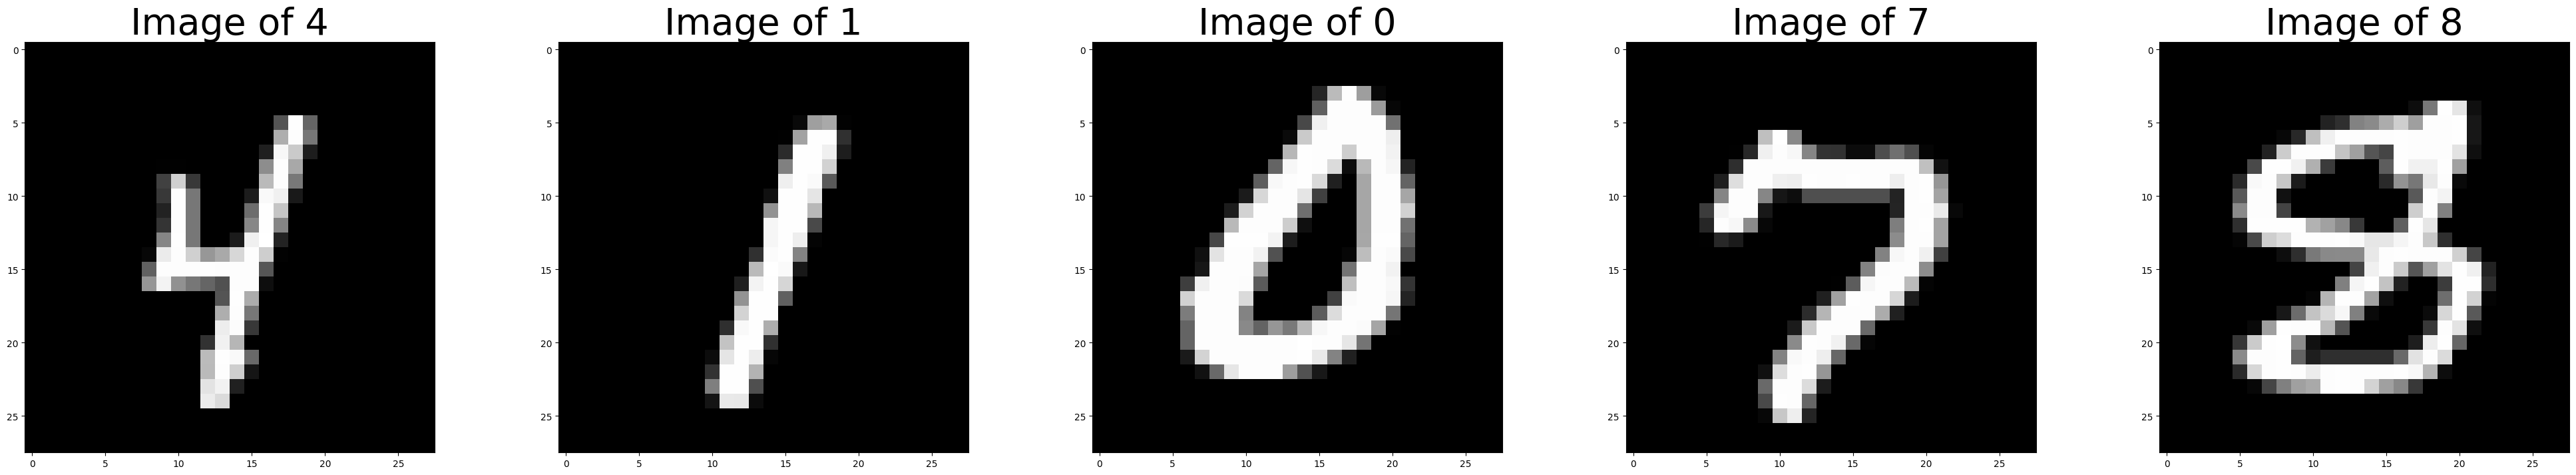

In [12]:
viz_mnist(mnist_x[:5], mnist_y[:5])

### Noise Step

Let us now demonstrate the noising process using Gaussian noise.

In [5]:
# Let's pick some images, like the first 5 again
sample_images = mnist_x[:5]

# Let's define some arbitrary noise schedule... say 0.003 --> 0.03 ... with 100 steps
sample_var_schedule = linear_var_schedule(0.003, 0.03, 512)
sample_alpha_ts = calc_alpha_ts(sample_var_schedule)
sample_alpha_ts_bar = calc_alpha_ts_bar(sample_alpha_ts)  

print("Sample timesteps", 512)
print("Sample var schedule has shape: ", sample_var_schedule.shape)
print("Sample alpha_ts_bar has shape: ", sample_alpha_ts_bar.shape)

Sample timesteps 512
Sample var schedule has shape:  (512,)
Sample alpha_ts_bar has shape:  (512,)


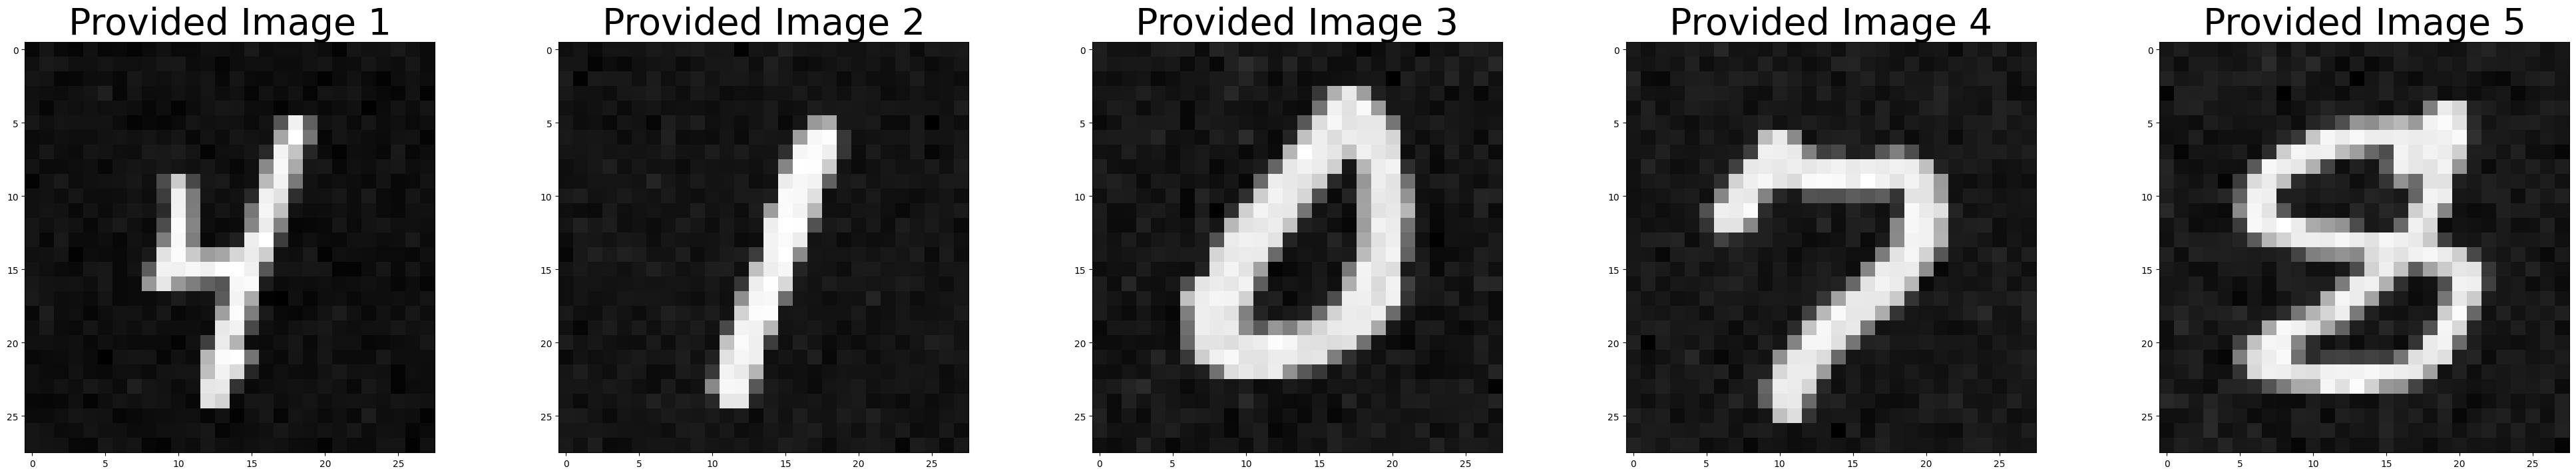

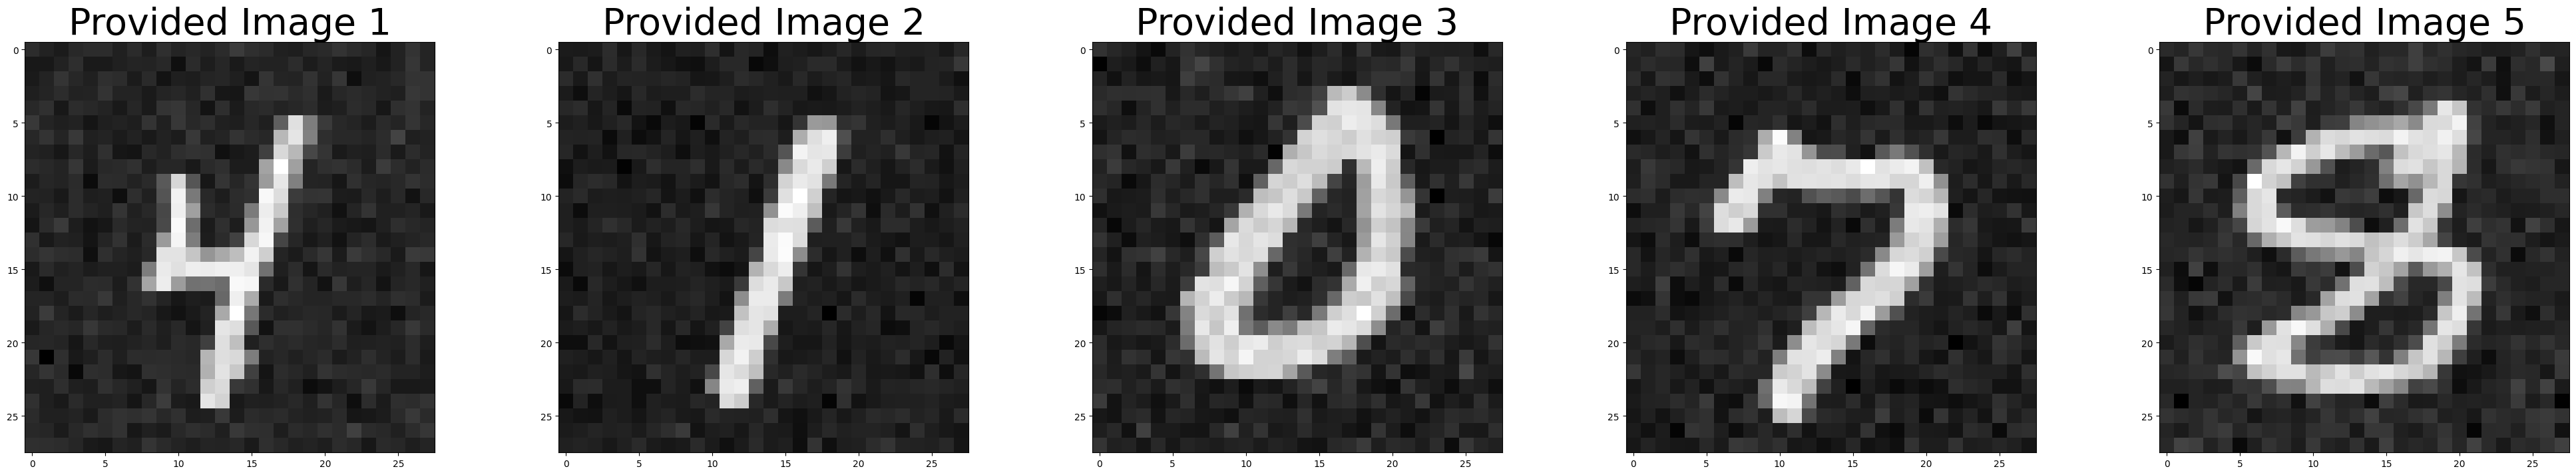

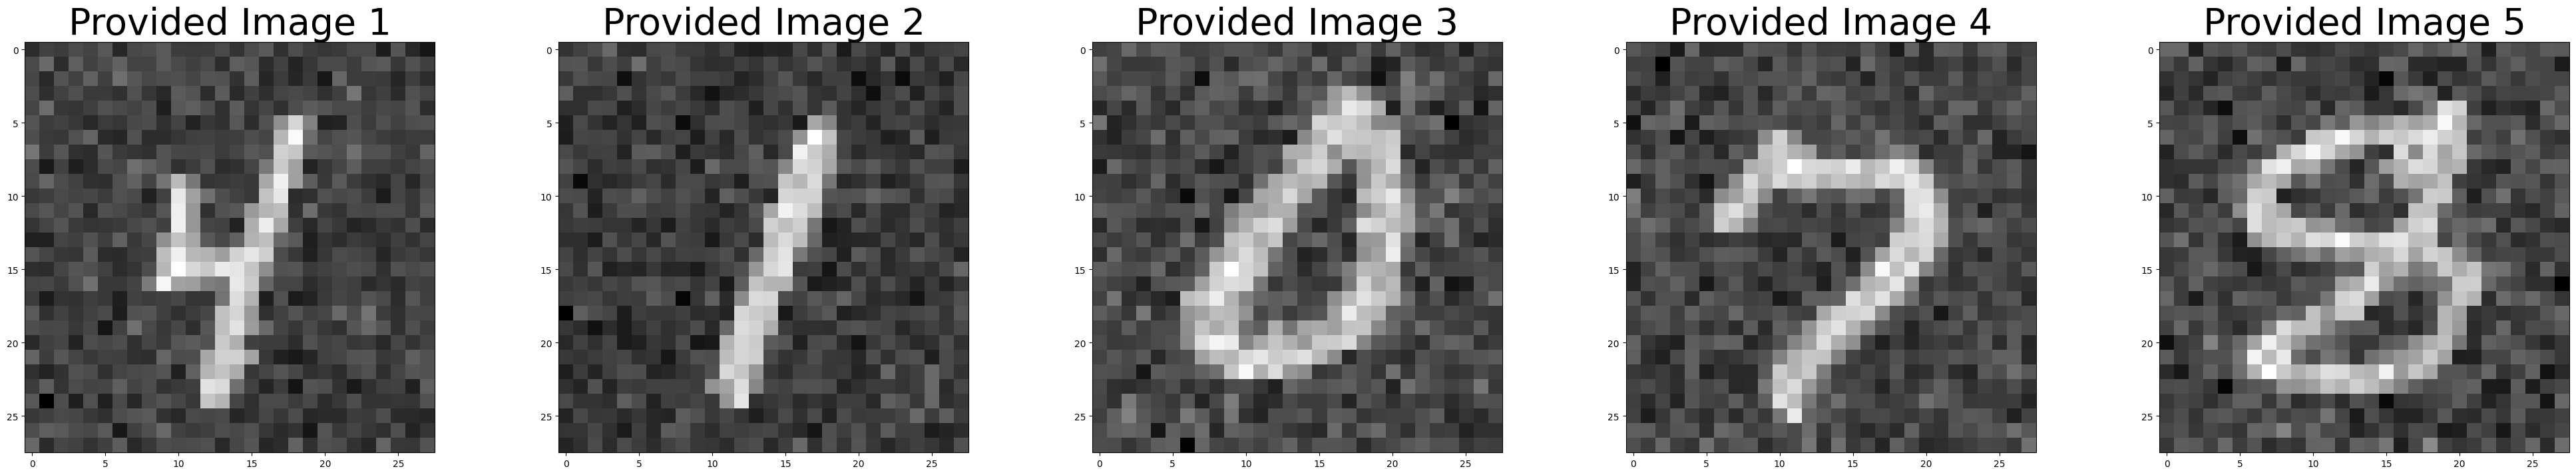

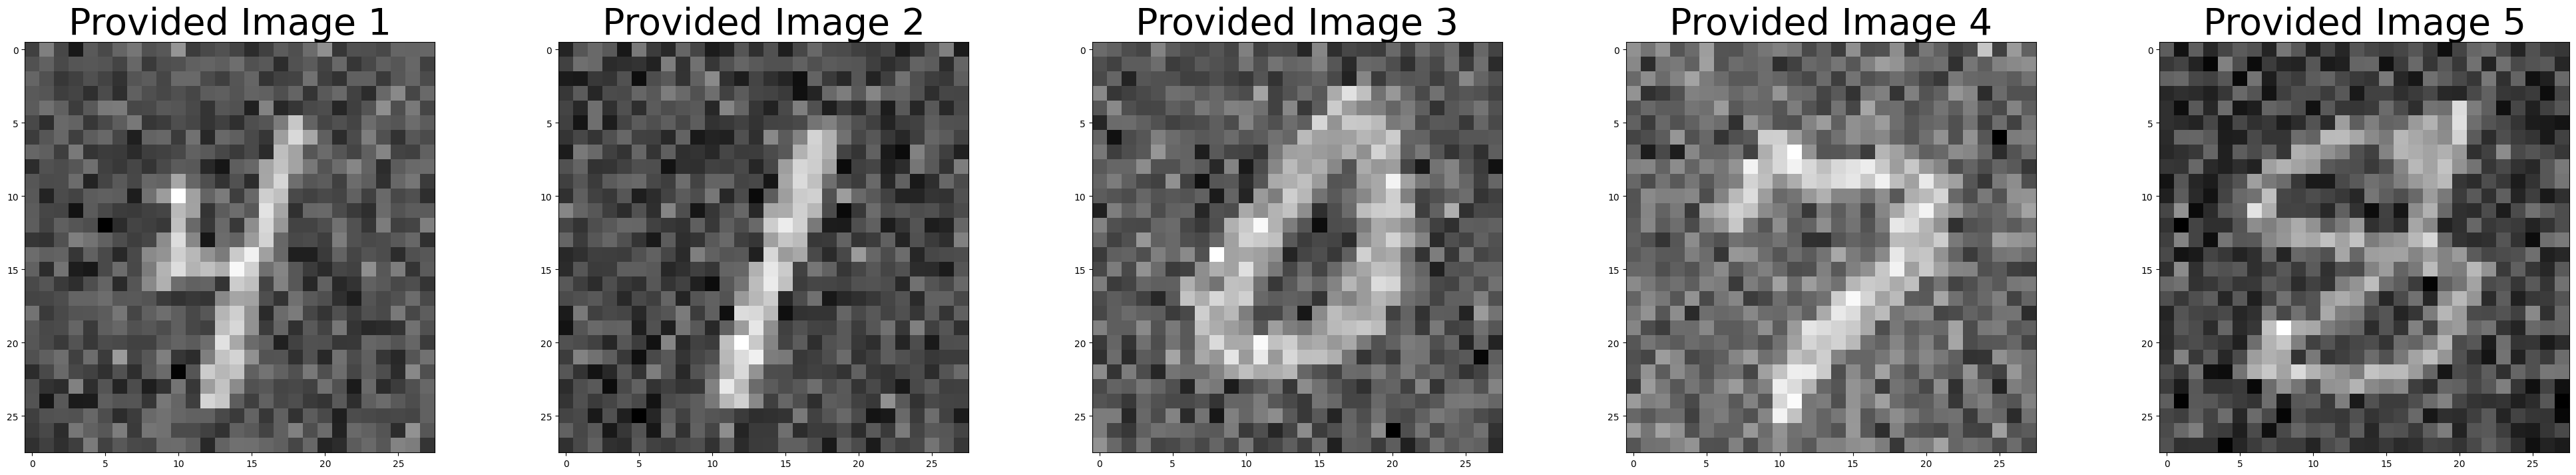

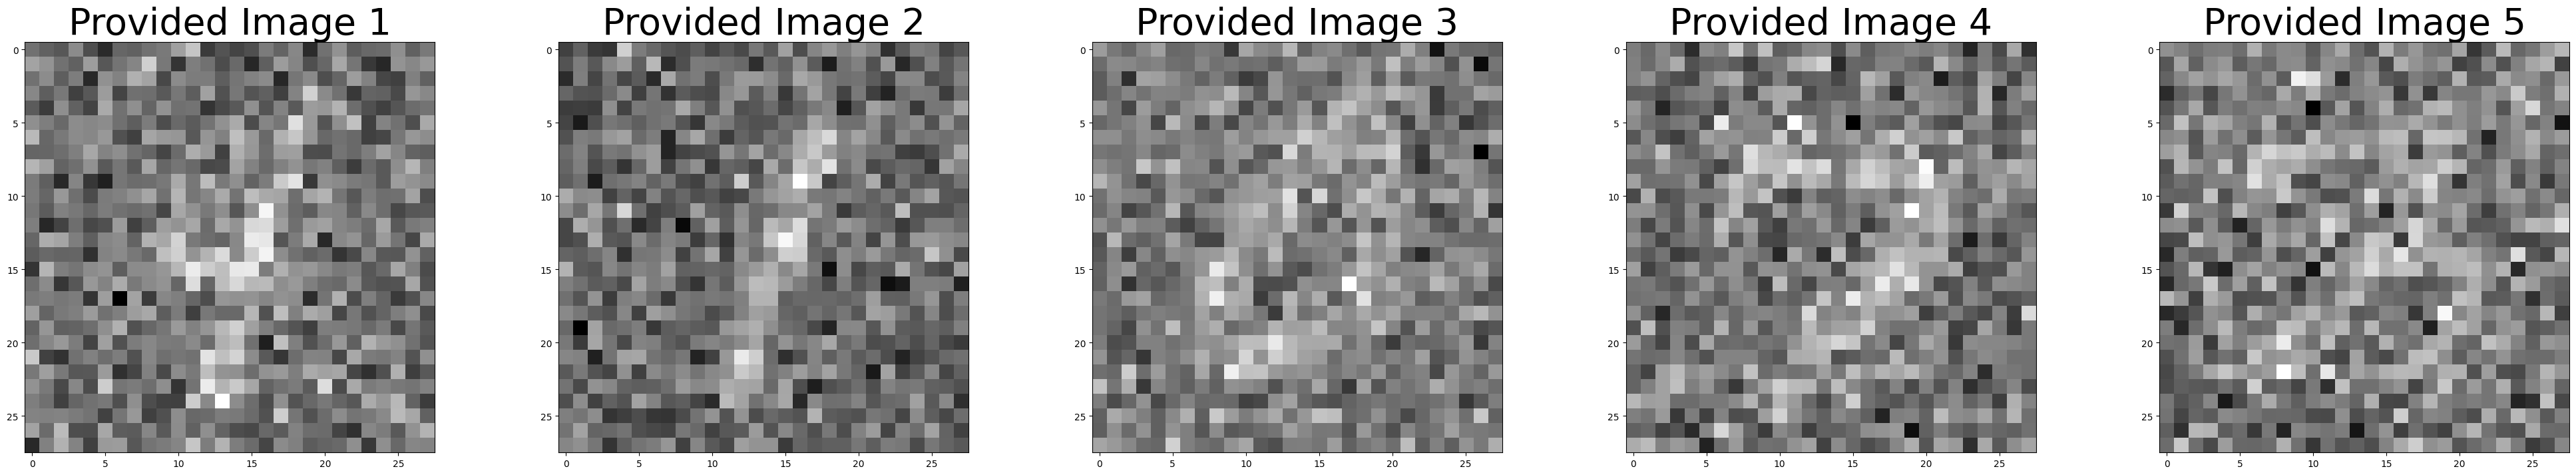

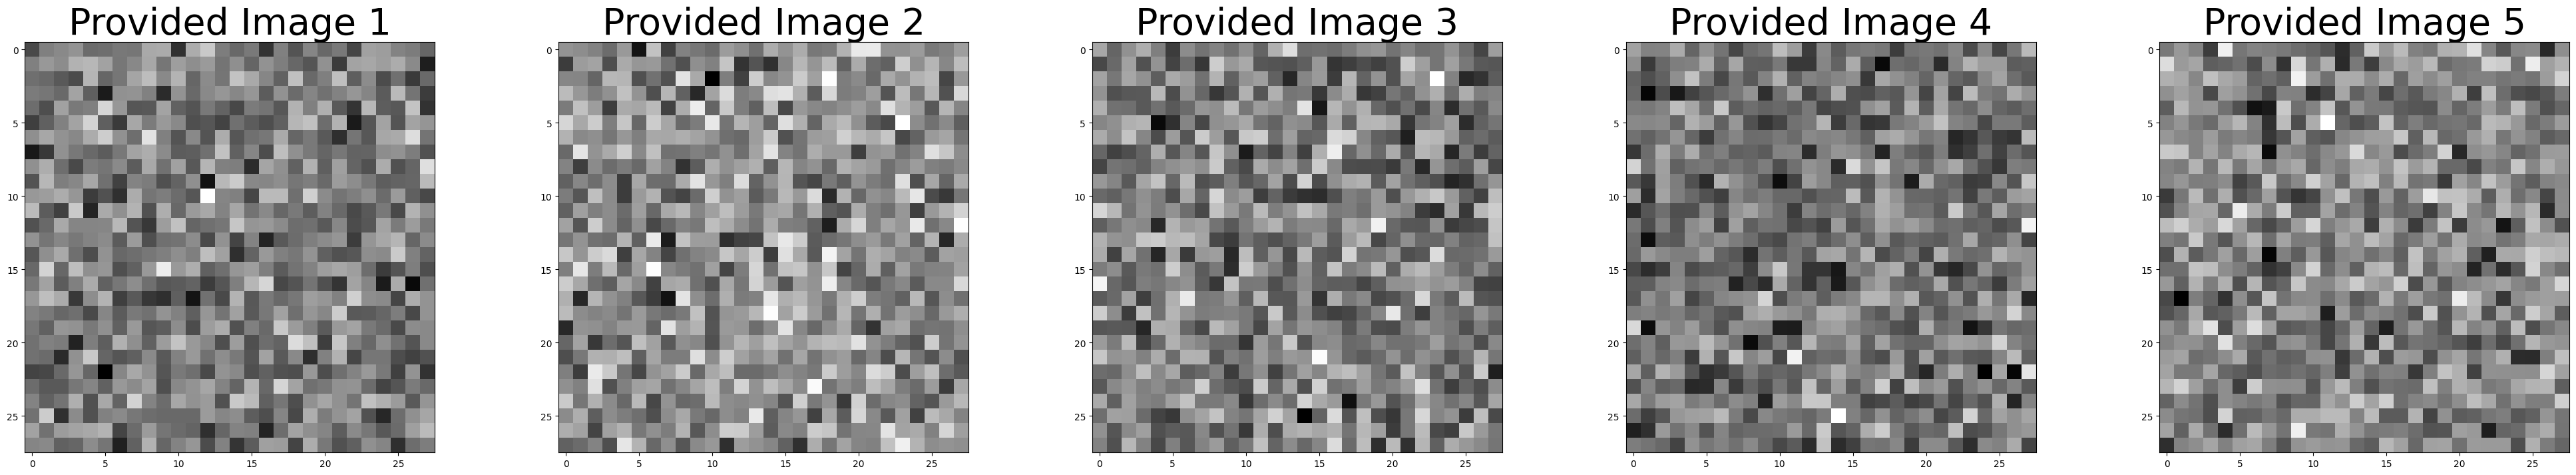

In [6]:
# Now for each image, I want to generate noise for step 2, 10, 50, 95... just some arbitrary
# values to demonstrate the functioning of the approach.

imgs_to_plot = np.zeros((6, 5, 28, 28))
for i, timestep in enumerate([2, 10, 50, 95, 200, 400]):
    nw_img, noise = gauss_noise_step(torch.from_numpy(sample_images), sample_alpha_ts_bar, timestep)
    imgs_to_plot[i] = nw_img.clone().numpy()

    viz_mnist(imgs_to_plot[i], title=f'Image{i}')

So the noise sampling works great. We can see how noise is applied quickly over many steps.

If the noise sampling is functional, we now need to train the reverse function.

### Quick Training

In [6]:
@torch.no_grad()
def sample_from_model(model, n, imgr, imgc, channels, alpha_ts, alpha_ts_bar, beta_ts, noise_steps=512, timestep=None):
    '''
    @model: The pytorch model to use for inference
    @n: The number of images to generate
    @imgr: Image rows for convenience
    @imgc: Image cols for convenience
    @channels: The image channels for convenience
    @noise_steps: The maximum possible noise steps 
    @timestep: The timestep to generate at. NONE => a random generation
    It is recommended to make noise steps small to ensure enough memory in the machine.

    @alpha_ts, alpha_ts_bar, beta: Noise reducing parameters 

    Note that if imgr and imgc do not align with training / the model
    construction this WILL NOT work.

    For convenience, ALL the generated images come from the same randomly chosen timestep
    '''

    alpha_ts = torch.from_numpy(alpha_ts).to(model.device)
    alpha_ts_bar = torch.from_numpy(alpha_ts_bar).to(model.device)
    beta_ts = torch.from_numpy(beta_ts).to(model.device)

    model.eval()
    with torch.no_grad():
        x = torch.randn((n, channels, imgr, imgc)).to(model.device)
        for i in tqdm(reversed(range(1, noise_steps)), position=0):

            t = (torch.ones(n) * i).long().to(model.device)

            predicted_noise = model(x.float(), i)
            alpha_proc = alpha_ts[t][:, None, None, None]
            alpha_bar_proc = alpha_ts_bar[t][:, None, None, None]
            beta_proc = beta_ts[t][:, None, None, None]

            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = 1 / torch.sqrt(alpha_proc) * (x - ((1 - alpha_proc) / (torch.sqrt(1 - alpha_bar_proc))) * predicted_noise) + torch.sqrt(beta_proc) * noise

    model.train()
    x = (x.clamp(-1, 1) + 1) / 2
    x = (x * 255).type(torch.uint8)

    return x.detach().cpu().numpy()


In [10]:
noise_steps = 512
n_epochs = 10

def train(X, Y, alpha_ts, alpha_ts_bar, beta, n_epochs=100, noise_steps=512, name="MODEL_DEFAULT_NAME", batch_size=64, save_every=5, 
          imgr=28, imgc=28, channels=1, logging_directory='Logging', lr=0.0003):
    # Initialize logging
    log_path = os.path.join(logging_directory, name)
    writer = SummaryWriter(os.path.join(logging_directory, name))
    
    model = DDPM(1, len(alpha_ts_bar), {'lr':lr})
    model = model.to(model.device)

    training_x = X[:, None, :, :]

    # Prepare tensors
    training_x = torch.from_numpy(training_x).float()
    training_y = torch.from_numpy(Y).float()

    # Prepare dataset
    dataset = TensorDataset(training_x, training_y) 
    dataloader = DataLoader(dataset, batch_size=64) 

    for epoch in range(n_epochs):
        ct = time.time()
        l = len(dataloader)
        counter = 0
        for batch_x, batch_y in tqdm(dataloader):
            timestep = np.random.randint(low=1, high=noise_steps) # Which timestep to use

            # Noise the batch...
            # The variance schedule is already loaded.
            new_images, true_noise = gauss_noise_step(batch_x, alpha_ts_bar, timestep)

            # New images comes back in shape (B, 1, 28, 28)
            predicted_noise = model(new_images, timestep)

            loss = model.backward(predicted_noise, true_noise) 

            writer.add_scalar('Training/MSE', loss.item(), global_step= counter + epoch * l)
            counter += 1  

        if epoch % save_every == 0 or epoch == n_epochs - 1:
            # Now we need to save sample images.
            images_to_save = sample_from_model(model, 5, imgr, imgc, channels, alpha_ts, alpha_ts_bar, beta, noise_steps, None)
            save_images(images_to_save, os.path.join(log_path, f'Images_{epoch}.png'))
            writer.add_images('Training/ImagesOverTime', torch.from_numpy(images_to_save), global_step=epoch)
        
        print(f"Epoch {epoch + 1} / {n_epochs} processed {l} batches in {time.time() - ct} sec.")

    return model


In [11]:
mnist_model = train(mnist_x, mnist_y, n_epochs, noise_steps)

Epoch 1 / 10 processed 938 batches in 223.77909755706787 sec. :: AVG LOSS => 0.15620540018066334
Epoch 2 / 10 processed 938 batches in 216.86718773841858 sec. :: AVG LOSS => 0.05847544126462803
Epoch 3 / 10 processed 938 batches in 210.61300253868103 sec. :: AVG LOSS => 0.048718365537536855
Epoch 4 / 10 processed 938 batches in 208.94627690315247 sec. :: AVG LOSS => 0.0489130619571292
Epoch 5 / 10 processed 938 batches in 207.13863396644592 sec. :: AVG LOSS => 0.040046943939908514
Epoch 6 / 10 processed 938 batches in 210.3641300201416 sec. :: AVG LOSS => 0.047570689962104534
Epoch 7 / 10 processed 938 batches in 204.88868737220764 sec. :: AVG LOSS => 0.043036646052781964
Epoch 8 / 10 processed 938 batches in 199.03915643692017 sec. :: AVG LOSS => 0.03675077357731545
Epoch 9 / 10 processed 938 batches in 199.02467608451843 sec. :: AVG LOSS => 0.03782195876638439
Epoch 10 / 10 processed 938 batches in 199.01817107200623 sec. :: AVG LOSS => 0.035492743958713116


In [12]:
torch.save(mnist_model.state_dict(), 'MODEL1.mdl')

511it [00:05, 102.10it/s]


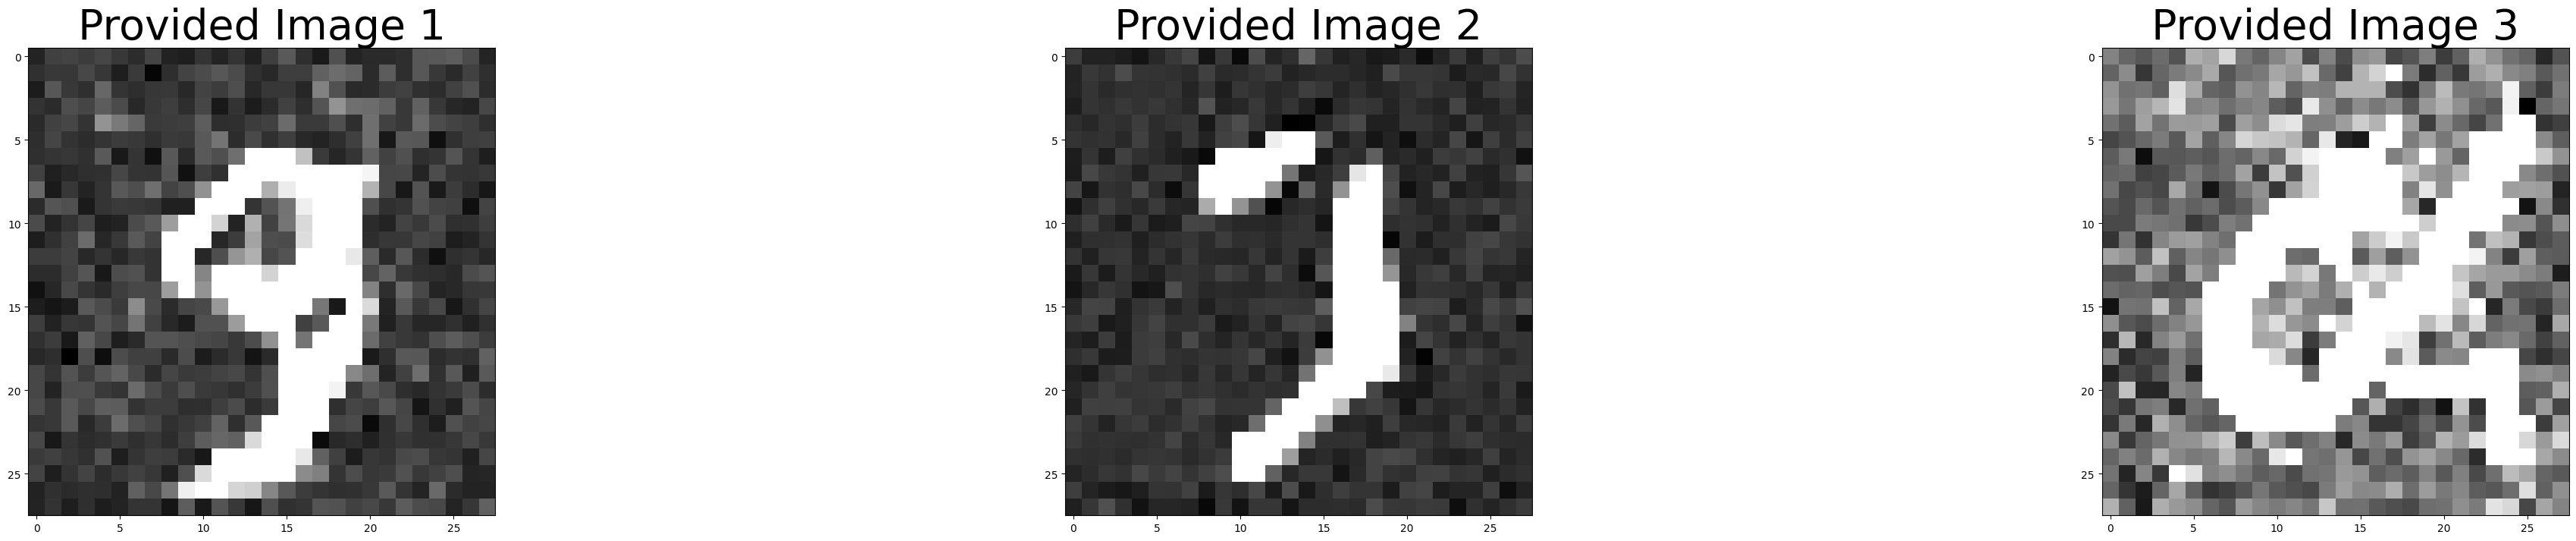

In [44]:
imgs = sample_from_model(mnist_model, 3, 28, 28, 1, sample_alpha_ts, sample_alpha_ts_bar, sample_var_schedule, timestep=450)
viz_mnist_wchannel(imgs)

Quick training results posted above.

### Long Training

In [11]:
# Reset the var. schedule based on the schedule given in paper

# Note that the following parameters are taken from Ho et al
noise_steps = 512
n_epochs = 100
lr = 2 * 10**(-4)

var_schedule = linear_var_schedule(0.0001, 0.02, noise_steps)
alpha_ts = calc_alpha_ts(var_schedule)
alpha_ts_bar = calc_alpha_ts_bar(alpha_ts)  

run_name = f"MODEL_PRIMARY_LR_{lr}"
trained_model = train(mnist_x, mnist_y, alpha_ts, alpha_ts_bar, var_schedule, n_epochs=n_epochs, noise_steps=noise_steps, name=run_name, batch_size=100, lr=lr)

100%|██████████| 938/938 [03:29<00:00,  4.48it/s]
511it [00:05, 86.92it/s]


(32, 152, 3)
Epoch 1 / 100 processed 938 batches in 215.1513330936432 sec.


100%|██████████| 938/938 [03:23<00:00,  4.60it/s]


Epoch 2 / 100 processed 938 batches in 203.77769708633423 sec.


100%|██████████| 938/938 [03:28<00:00,  4.51it/s]


Epoch 3 / 100 processed 938 batches in 208.0501594543457 sec.


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


Epoch 4 / 100 processed 938 batches in 209.41814374923706 sec.


100%|██████████| 938/938 [03:28<00:00,  4.49it/s]


Epoch 5 / 100 processed 938 batches in 208.76060390472412 sec.


100%|██████████| 938/938 [03:27<00:00,  4.52it/s]
511it [00:05, 88.59it/s]


(32, 152, 3)
Epoch 6 / 100 processed 938 batches in 213.4452931880951 sec.


100%|██████████| 938/938 [03:20<00:00,  4.68it/s]


Epoch 7 / 100 processed 938 batches in 200.54910850524902 sec.


100%|██████████| 938/938 [03:20<00:00,  4.68it/s]


Epoch 8 / 100 processed 938 batches in 200.48084568977356 sec.


100%|██████████| 938/938 [03:20<00:00,  4.68it/s]


Epoch 9 / 100 processed 938 batches in 200.58374977111816 sec.


100%|██████████| 938/938 [03:20<00:00,  4.68it/s]


Epoch 10 / 100 processed 938 batches in 200.60497760772705 sec.


100%|██████████| 938/938 [03:27<00:00,  4.53it/s]
511it [00:05, 86.19it/s]


(32, 152, 3)
Epoch 11 / 100 processed 938 batches in 213.0901482105255 sec.


100%|██████████| 938/938 [03:29<00:00,  4.49it/s]


Epoch 12 / 100 processed 938 batches in 209.04264426231384 sec.


100%|██████████| 938/938 [03:17<00:00,  4.75it/s]


Epoch 13 / 100 processed 938 batches in 197.42812180519104 sec.


100%|██████████| 938/938 [03:22<00:00,  4.64it/s]


Epoch 14 / 100 processed 938 batches in 202.32226371765137 sec.


100%|██████████| 938/938 [03:18<00:00,  4.73it/s]


Epoch 15 / 100 processed 938 batches in 198.40361309051514 sec.


100%|██████████| 938/938 [03:35<00:00,  4.36it/s]
511it [00:06, 84.40it/s]


(32, 152, 3)
Epoch 16 / 100 processed 938 batches in 221.33219647407532 sec.


100%|██████████| 938/938 [03:34<00:00,  4.37it/s]


Epoch 17 / 100 processed 938 batches in 214.4947226047516 sec.


100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 18 / 100 processed 938 batches in 220.29671382904053 sec.


100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 19 / 100 processed 938 batches in 220.89875102043152 sec.


100%|██████████| 938/938 [03:40<00:00,  4.25it/s]


Epoch 20 / 100 processed 938 batches in 220.91173219680786 sec.


100%|██████████| 938/938 [03:40<00:00,  4.25it/s]
511it [00:06, 82.27it/s]


(32, 152, 3)
Epoch 21 / 100 processed 938 batches in 226.71258783340454 sec.


100%|██████████| 938/938 [03:44<00:00,  4.18it/s]


Epoch 22 / 100 processed 938 batches in 224.46117496490479 sec.


100%|██████████| 938/938 [03:40<00:00,  4.26it/s]


Epoch 23 / 100 processed 938 batches in 220.28451824188232 sec.


100%|██████████| 938/938 [03:44<00:00,  4.19it/s]


Epoch 24 / 100 processed 938 batches in 224.0908784866333 sec.


100%|██████████| 938/938 [03:34<00:00,  4.37it/s]


Epoch 25 / 100 processed 938 batches in 214.57094812393188 sec.


100%|██████████| 938/938 [03:27<00:00,  4.51it/s]
511it [00:05, 86.71it/s]


(32, 152, 3)
Epoch 26 / 100 processed 938 batches in 213.8910517692566 sec.


100%|██████████| 938/938 [03:27<00:00,  4.52it/s]


Epoch 27 / 100 processed 938 batches in 207.49305176734924 sec.


100%|██████████| 938/938 [03:23<00:00,  4.62it/s]


Epoch 28 / 100 processed 938 batches in 203.17007660865784 sec.


100%|██████████| 938/938 [03:20<00:00,  4.69it/s]


Epoch 29 / 100 processed 938 batches in 200.0865638256073 sec.


100%|██████████| 938/938 [03:23<00:00,  4.61it/s]


Epoch 30 / 100 processed 938 batches in 203.6365623474121 sec.


100%|██████████| 938/938 [03:27<00:00,  4.51it/s]
511it [00:05, 86.74it/s]


(32, 152, 3)
Epoch 31 / 100 processed 938 batches in 213.84002494812012 sec.


100%|██████████| 938/938 [03:27<00:00,  4.51it/s]


Epoch 32 / 100 processed 938 batches in 207.96856379508972 sec.


100%|██████████| 938/938 [03:23<00:00,  4.60it/s]


Epoch 33 / 100 processed 938 batches in 203.73502373695374 sec.


100%|██████████| 938/938 [03:20<00:00,  4.69it/s]


Epoch 34 / 100 processed 938 batches in 200.0700261592865 sec.


100%|██████████| 938/938 [03:20<00:00,  4.69it/s]


Epoch 35 / 100 processed 938 batches in 200.05354475975037 sec.


100%|██████████| 938/938 [03:20<00:00,  4.69it/s]
511it [00:05, 89.27it/s]


(32, 152, 3)
Epoch 36 / 100 processed 938 batches in 205.77557349205017 sec.


100%|██████████| 938/938 [03:19<00:00,  4.69it/s]


Epoch 37 / 100 processed 938 batches in 199.79155254364014 sec.


100%|██████████| 938/938 [03:19<00:00,  4.69it/s]


Epoch 38 / 100 processed 938 batches in 199.85151267051697 sec.


100%|██████████| 938/938 [03:19<00:00,  4.69it/s]


Epoch 39 / 100 processed 938 batches in 199.82151341438293 sec.


100%|██████████| 938/938 [03:24<00:00,  4.58it/s]


Epoch 40 / 100 processed 938 batches in 204.73458576202393 sec.


100%|██████████| 938/938 [03:33<00:00,  4.39it/s]
511it [00:06, 84.62it/s]


(32, 152, 3)
Epoch 41 / 100 processed 938 batches in 219.84592080116272 sec.


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


Epoch 42 / 100 processed 938 batches in 209.7744779586792 sec.


100%|██████████| 938/938 [03:29<00:00,  4.47it/s]


Epoch 43 / 100 processed 938 batches in 209.63410186767578 sec.


100%|██████████| 938/938 [03:28<00:00,  4.49it/s]


Epoch 44 / 100 processed 938 batches in 208.73241066932678 sec.


100%|██████████| 938/938 [03:33<00:00,  4.38it/s]


Epoch 45 / 100 processed 938 batches in 213.93285465240479 sec.


100%|██████████| 938/938 [03:28<00:00,  4.50it/s]
511it [00:05, 90.14it/s]


(32, 152, 3)
Epoch 46 / 100 processed 938 batches in 214.11310482025146 sec.


100%|██████████| 938/938 [03:34<00:00,  4.38it/s]


Epoch 47 / 100 processed 938 batches in 214.2438941001892 sec.


100%|██████████| 938/938 [03:34<00:00,  4.38it/s]


Epoch 48 / 100 processed 938 batches in 214.1112298965454 sec.


100%|██████████| 938/938 [03:34<00:00,  4.38it/s]


Epoch 49 / 100 processed 938 batches in 214.38409328460693 sec.


100%|██████████| 938/938 [03:34<00:00,  4.37it/s]


Epoch 50 / 100 processed 938 batches in 214.66061902046204 sec.


100%|██████████| 938/938 [03:33<00:00,  4.39it/s]
511it [00:06, 84.97it/s]


(32, 152, 3)
Epoch 51 / 100 processed 938 batches in 219.73797702789307 sec.


100%|██████████| 938/938 [03:33<00:00,  4.38it/s]


Epoch 52 / 100 processed 938 batches in 213.95523309707642 sec.


100%|██████████| 938/938 [03:33<00:00,  4.39it/s]


Epoch 53 / 100 processed 938 batches in 213.84798216819763 sec.


100%|██████████| 938/938 [03:26<00:00,  4.54it/s]


Epoch 54 / 100 processed 938 batches in 206.68801188468933 sec.


100%|██████████| 938/938 [03:17<00:00,  4.76it/s]


Epoch 55 / 100 processed 938 batches in 197.19953632354736 sec.


100%|██████████| 938/938 [03:17<00:00,  4.76it/s]
511it [00:05, 90.27it/s]


(32, 152, 3)
Epoch 56 / 100 processed 938 batches in 202.82599902153015 sec.


100%|██████████| 938/938 [03:17<00:00,  4.76it/s]


Epoch 57 / 100 processed 938 batches in 197.07602858543396 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 58 / 100 processed 938 batches in 196.77221083641052 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 59 / 100 processed 938 batches in 196.7645561695099 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 60 / 100 processed 938 batches in 196.77458691596985 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]
511it [00:05, 90.55it/s]


(32, 152, 3)
Epoch 61 / 100 processed 938 batches in 202.43862462043762 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 62 / 100 processed 938 batches in 196.79853701591492 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 63 / 100 processed 938 batches in 196.80804705619812 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 64 / 100 processed 938 batches in 196.80516052246094 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]


Epoch 65 / 100 processed 938 batches in 196.80353260040283 sec.


100%|██████████| 938/938 [03:16<00:00,  4.77it/s]
511it [00:05, 90.31it/s]


(32, 152, 3)
Epoch 66 / 100 processed 938 batches in 202.48111152648926 sec.


100%|██████████| 938/938 [03:18<00:00,  4.73it/s]


Epoch 67 / 100 processed 938 batches in 198.29819703102112 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 68 / 100 processed 938 batches in 198.71968054771423 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 69 / 100 processed 938 batches in 198.70105957984924 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 70 / 100 processed 938 batches in 198.73655915260315 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]
511it [00:05, 89.71it/s]


(32, 152, 3)
Epoch 71 / 100 processed 938 batches in 204.40800523757935 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 72 / 100 processed 938 batches in 198.7071042060852 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 73 / 100 processed 938 batches in 198.69455552101135 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 74 / 100 processed 938 batches in 198.68103075027466 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 75 / 100 processed 938 batches in 198.70403575897217 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]
511it [00:05, 89.74it/s]


(32, 152, 3)
Epoch 76 / 100 processed 938 batches in 204.39352560043335 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 77 / 100 processed 938 batches in 198.68651366233826 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 78 / 100 processed 938 batches in 198.71509265899658 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 79 / 100 processed 938 batches in 198.6630277633667 sec.


100%|██████████| 938/938 [03:18<00:00,  4.72it/s]


Epoch 80 / 100 processed 938 batches in 198.67405080795288 sec.


100%|██████████| 938/938 [03:21<00:00,  4.66it/s]
511it [00:05, 87.88it/s]


(32, 152, 3)
Epoch 81 / 100 processed 938 batches in 207.01265335083008 sec.


100%|██████████| 938/938 [03:28<00:00,  4.49it/s]


Epoch 82 / 100 processed 938 batches in 208.9882881641388 sec.


100%|██████████| 938/938 [03:24<00:00,  4.59it/s]


Epoch 83 / 100 processed 938 batches in 204.18069076538086 sec.


100%|██████████| 938/938 [03:20<00:00,  4.69it/s]


Epoch 84 / 100 processed 938 batches in 200.01339101791382 sec.


100%|██████████| 938/938 [03:20<00:00,  4.67it/s]


Epoch 85 / 100 processed 938 batches in 200.84675669670105 sec.


100%|██████████| 938/938 [03:22<00:00,  4.63it/s]
511it [00:05, 89.08it/s]


(32, 152, 3)
Epoch 86 / 100 processed 938 batches in 208.20655727386475 sec.


100%|██████████| 938/938 [03:28<00:00,  4.51it/s]


Epoch 87 / 100 processed 938 batches in 208.10870790481567 sec.


100%|██████████| 938/938 [03:28<00:00,  4.51it/s]


Epoch 88 / 100 processed 938 batches in 208.0295844078064 sec.


100%|██████████| 938/938 [03:27<00:00,  4.52it/s]


Epoch 89 / 100 processed 938 batches in 207.6711301803589 sec.


100%|██████████| 938/938 [03:28<00:00,  4.50it/s]


Epoch 90 / 100 processed 938 batches in 208.3490800857544 sec.


100%|██████████| 938/938 [03:27<00:00,  4.53it/s]
511it [00:05, 87.14it/s]


(32, 152, 3)
Epoch 91 / 100 processed 938 batches in 213.13321900367737 sec.


100%|██████████| 938/938 [03:28<00:00,  4.50it/s]


Epoch 92 / 100 processed 938 batches in 208.22687339782715 sec.


100%|██████████| 938/938 [03:29<00:00,  4.48it/s]


Epoch 93 / 100 processed 938 batches in 209.55868768692017 sec.


100%|██████████| 938/938 [03:28<00:00,  4.50it/s]


Epoch 94 / 100 processed 938 batches in 208.215407371521 sec.


100%|██████████| 938/938 [03:27<00:00,  4.52it/s]


Epoch 95 / 100 processed 938 batches in 207.35973262786865 sec.


100%|██████████| 938/938 [03:27<00:00,  4.53it/s]
511it [00:05, 87.10it/s]


(32, 152, 3)
Epoch 96 / 100 processed 938 batches in 212.9002788066864 sec.


100%|██████████| 938/938 [03:26<00:00,  4.53it/s]


Epoch 97 / 100 processed 938 batches in 206.893545627594 sec.


100%|██████████| 938/938 [03:27<00:00,  4.52it/s]


Epoch 98 / 100 processed 938 batches in 207.66366505622864 sec.


100%|██████████| 938/938 [03:28<00:00,  4.49it/s]


Epoch 99 / 100 processed 938 batches in 208.88455653190613 sec.


100%|██████████| 938/938 [03:27<00:00,  4.52it/s]
511it [00:05, 87.37it/s]


(32, 152, 3)
Epoch 100 / 100 processed 938 batches in 213.6097128391266 sec.


### EMA Training

In [8]:
from copy import deepcopy as dc

def train_EMA(X, Y, alpha_ts, alpha_ts_bar, beta, n_epochs=100, noise_steps=512, name="MODEL_DEFAULT_NAME", batch_size=64, save_every=5, 
          imgr=28, imgc=28, channels=1, logging_directory='Logging', lr=0.0003):
    # Initialize logging
    log_path = os.path.join(logging_directory, name)
    writer = SummaryWriter(os.path.join(logging_directory, name))
    
    model = DDPM(1, len(alpha_ts_bar), {'lr':lr})
    model = model.to(model.device)

    training_x = X[:, None, :, :]

    # Prepare tensors
    training_x = torch.from_numpy(training_x).float()
    training_y = torch.from_numpy(Y).float()

    # Prepare dataset
    dataset = TensorDataset(training_x, training_y) 
    dataloader = DataLoader(dataset, batch_size=64) 

    # Prepare EMA trainer
    ema_t = ema_trainer(1000, 0.992)

    # EMA model is just a straight copy with parameters tracked separately.
    ema_mod = dc(model).requires_grad_(False).eval()

    for epoch in range(n_epochs):
        ct = time.time()
        l = len(dataloader)
        counter = 0
        for batch_x, batch_y in tqdm(dataloader):
            timestep = np.random.randint(low=1, high=noise_steps) # Which timestep to use

            # Noise the batch...
            # The variance schedule is already loaded.
            new_images, true_noise = gauss_noise_step(batch_x, alpha_ts_bar, timestep)

            # New images comes back in shape (B, 1, 28, 28)
            predicted_noise = model(new_images, timestep)
            ema_predicted_noise = ema_mod(new_images, timestep)

            loss = model.backward(predicted_noise, true_noise) 
            ema_loss = ema_mod.backward(ema_predicted_noise, true_noise, no_grad=True)
            ema_t.step_training(model, ema_mod, counter + epoch * l)

            writer.add_scalar('Training/MSE', loss.item(), global_step= counter + epoch * l)
            writer.add_scalar('Training/EMA_MSE', ema_loss.item(), global_step= counter + epoch * l)
            counter += 1  

        if epoch % save_every == 0 or epoch == n_epochs - 1:
            # Now we need to save sample images.
            images_to_save = sample_from_model(model, 5, imgr, imgc, channels, alpha_ts, alpha_ts_bar, beta, noise_steps, None)
            ema_images_to_save = sample_from_model(ema_mod, 5, imgr, imgc, channels, alpha_ts, alpha_ts_bar, beta, noise_steps, None)
            save_images(images_to_save, os.path.join(log_path, f'Images_{epoch}_{name}.png'))
            save_images(ema_images_to_save, os.path.join(log_path, f'Images_{epoch}_{name}_EMA.png'))
            writer.add_images('Training/ImagesOverTime', torch.from_numpy(images_to_save), global_step=epoch)
            writer.add_images('Training/EMAImagesOverTime', torch.from_numpy(ema_images_to_save), global_step=epoch)
            torch.save(model.state_dict(), os.path.join('Models', name + str(epoch)))
            torch.save(ema_mod.state_dict(), os.path.join('Models', name + str(epoch) + 'EMA'))
        
        print(f"Epoch {epoch + 1} / {n_epochs} processed {l} batches in {time.time() - ct} sec.")

    return model

In [10]:
# Reset the var. schedule based on the schedule given in paper

# Note that the following parameters are taken from Ho et al
noise_steps = 512
n_epochs = 100
lr = 2 * 10**(-4)

var_schedule = linear_var_schedule(0.0001, 0.02, noise_steps)
alpha_ts = calc_alpha_ts(var_schedule)
alpha_ts_bar = calc_alpha_ts_bar(alpha_ts)  

run_name = f"MODEL_PRIMARY_LR_{lr}_EMA_2"
trained_model = train_EMA(mnist_x, mnist_y, alpha_ts, alpha_ts_bar, var_schedule, n_epochs=n_epochs, noise_steps=noise_steps, name=run_name, batch_size=100, lr=lr)

100%|██████████| 938/938 [04:36<00:00,  3.39it/s]
511it [00:05, 88.33it/s]
511it [00:05, 90.16it/s]


(32, 152, 3)
(32, 152, 3)
Epoch 1 / 100 processed 938 batches in 288.553156375885 sec.


100%|██████████| 938/938 [04:38<00:00,  3.37it/s]


Epoch 2 / 100 processed 938 batches in 278.0109145641327 sec.


100%|██████████| 938/938 [04:48<00:00,  3.26it/s]


Epoch 3 / 100 processed 938 batches in 288.0183963775635 sec.


100%|██████████| 938/938 [04:51<00:00,  3.22it/s]


Epoch 4 / 100 processed 938 batches in 291.2563076019287 sec.


100%|██████████| 938/938 [04:48<00:00,  3.25it/s]


Epoch 5 / 100 processed 938 batches in 288.5144109725952 sec.


100%|██████████| 938/938 [04:48<00:00,  3.26it/s]
511it [00:05, 86.14it/s]
511it [00:05, 86.63it/s]


(32, 152, 3)
(32, 152, 3)
Epoch 6 / 100 processed 938 batches in 300.1685359477997 sec.


100%|██████████| 938/938 [04:50<00:00,  3.23it/s]


Epoch 7 / 100 processed 938 batches in 290.0289316177368 sec.


100%|██████████| 938/938 [04:52<00:00,  3.21it/s]


Epoch 8 / 100 processed 938 batches in 292.31720757484436 sec.


100%|██████████| 938/938 [04:52<00:00,  3.21it/s]


Epoch 9 / 100 processed 938 batches in 292.14503264427185 sec.


100%|██████████| 938/938 [04:50<00:00,  3.23it/s]


Epoch 10 / 100 processed 938 batches in 290.62881207466125 sec.


100%|██████████| 938/938 [04:51<00:00,  3.21it/s]
511it [00:06, 84.42it/s]
511it [00:06, 84.60it/s]


(32, 152, 3)
(32, 152, 3)
Epoch 11 / 100 processed 938 batches in 304.2405915260315 sec.


100%|██████████| 938/938 [04:37<00:00,  3.38it/s]


Epoch 12 / 100 processed 938 batches in 277.80027508735657 sec.


100%|██████████| 938/938 [04:38<00:00,  3.37it/s]


Epoch 13 / 100 processed 938 batches in 278.08637022972107 sec.


100%|██████████| 938/938 [04:38<00:00,  3.36it/s]


Epoch 14 / 100 processed 938 batches in 278.9743881225586 sec.


100%|██████████| 938/938 [04:35<00:00,  3.41it/s]


Epoch 15 / 100 processed 938 batches in 275.17185258865356 sec.


100%|██████████| 938/938 [04:36<00:00,  3.39it/s]
511it [00:05, 90.15it/s]
511it [00:05, 89.39it/s]


(32, 152, 3)
(32, 152, 3)
Epoch 16 / 100 processed 938 batches in 288.16356587409973 sec.


 51%|█████▏    | 482/938 [02:25<02:17,  3.32it/s]


KeyboardInterrupt: 